# Project Final Report
 
Group: project-008-4  <br><br>

# Introduction

This project focuses on the prediction of playtime for Minecraft players. UBC Computer Science researcher Frank Wood and his team constructed a Minecraft server that collects data regarding players' behaviours. Their team aims to study how players interact with strangers in an online game environment. Using the data collected in this study, including variables such as age, gender, experience, and subscription status, this project aims to determine the kinds of players that are most likely to contribute to large amounts of data; in other words, long playtimes. 
This project utilizes the “players.csv” dataset to construct a prediction model. This dataset contains 196 observations. Each observation represents the data of one player registered on the server. 9 variables/columns are present in the dataset; each variable indicates a player’s identity. These variables are: 

**Categorical:**
- Minecraft experience level (beginner/amateur/regular/veteran/pro)
- player gender (male/female/non-binary/agender/two-spirited/prefer not to say) 
- individual ID 
- organization name
- hashed email 
- player's subscription status to the Plaicraft email list (true/false)

**Numerical:**
- played_hours (number of hours a player contributed ranging from 0 to 223.1) 
- player age (ranging from 9 to 99). 


In [57]:
#load the necessary packages
library(repr)
library(themis)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [58]:
#load the players data set
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players <- read_csv(url)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [59]:
#convert the players data set into a tidy format by removing unnecessary columns
players_tidy <- players |> 
    select(experience:age, -hashedEmail, -name) #|> #removed the hashedEmail and name columns
head(players_tidy)

experience,subscribe,played_hours,gender,age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


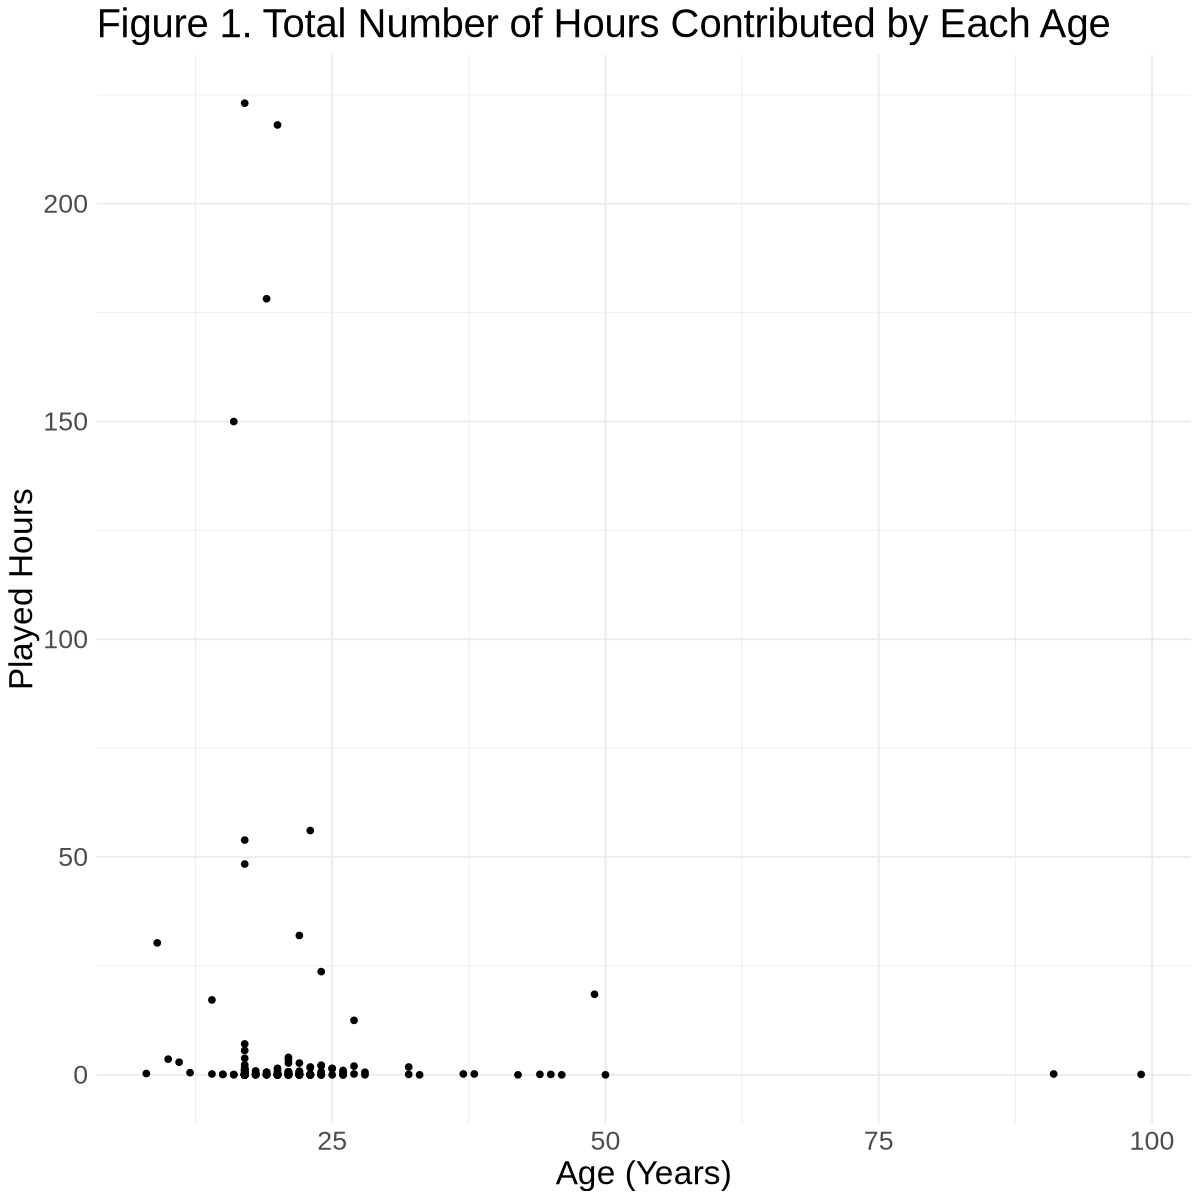

In [60]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(players_tidy, aes(x = age, y = played_hours)) +
  geom_point() + 
  labs(
    title = "Figure 1. Total Number of Hours Contributed by Each Age",
    x = "Age (Years)",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 20))

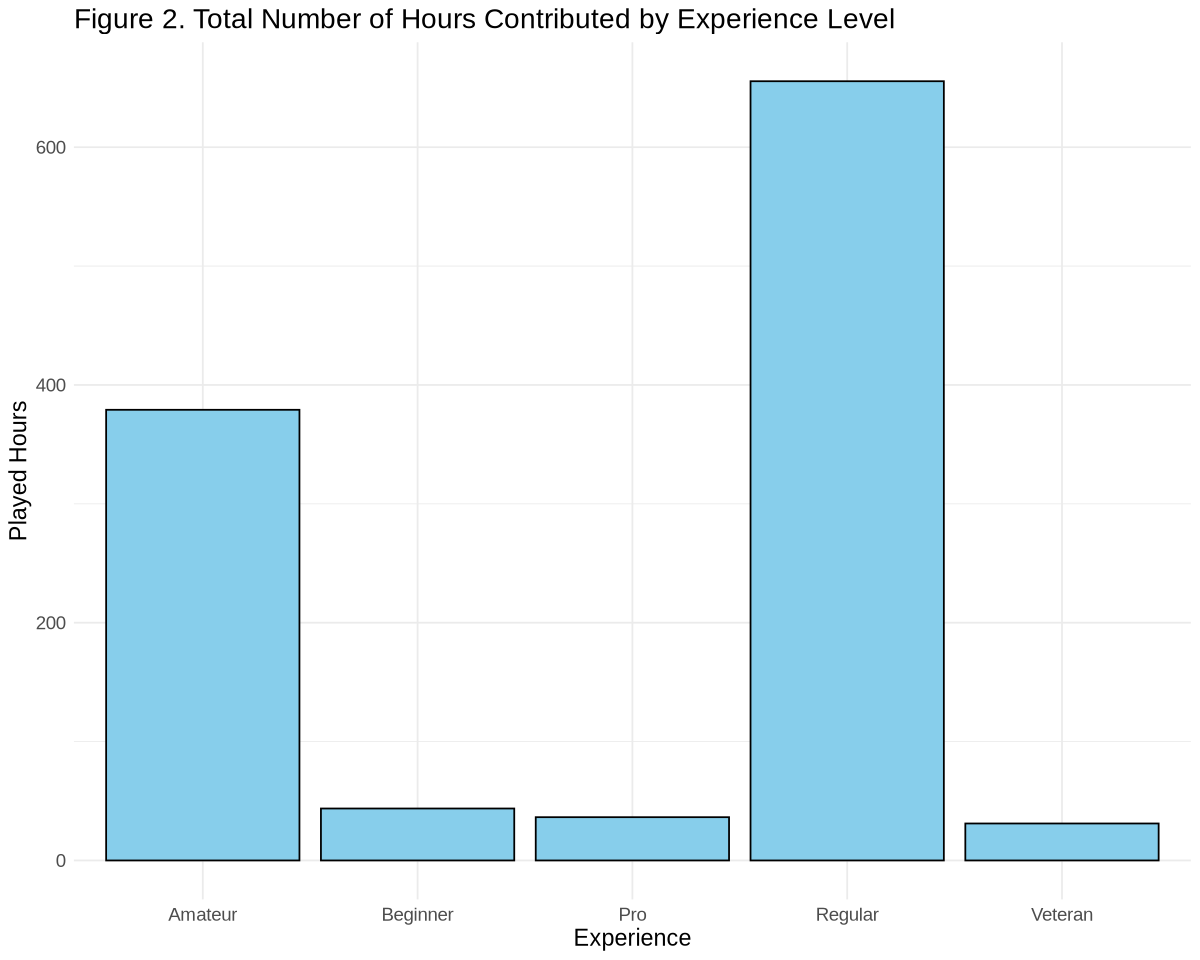

In [61]:
options(repr.plot.width = 10, repr.plot.height = 8)
experience_summary <- players_tidy |> 
  group_by(experience) |> 
  summarize(total_hours = sum(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(experience_summary, aes(x = experience, y = total_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 2. Total Number of Hours Contributed by Experience Level",
    x = "Experience",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

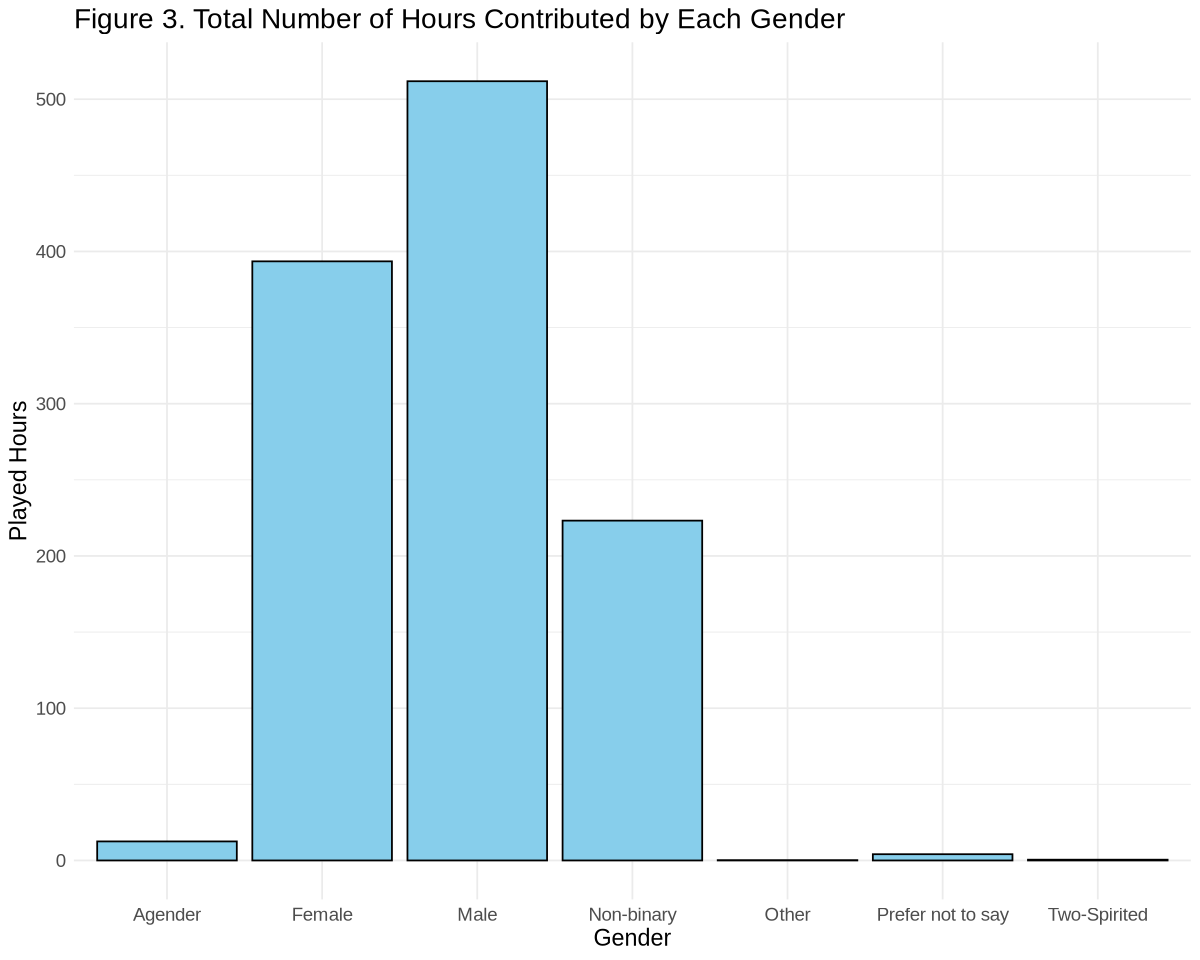

In [62]:
options(repr.plot.width = 10, repr.plot.height = 8)
gender_summary <- players_tidy |> 
  group_by(gender) |> 
  summarize(total_hours = sum(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(gender_summary, aes(x = gender, y = total_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 3. Total Number of Hours Contributed by Each Gender",
    x = "Gender",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

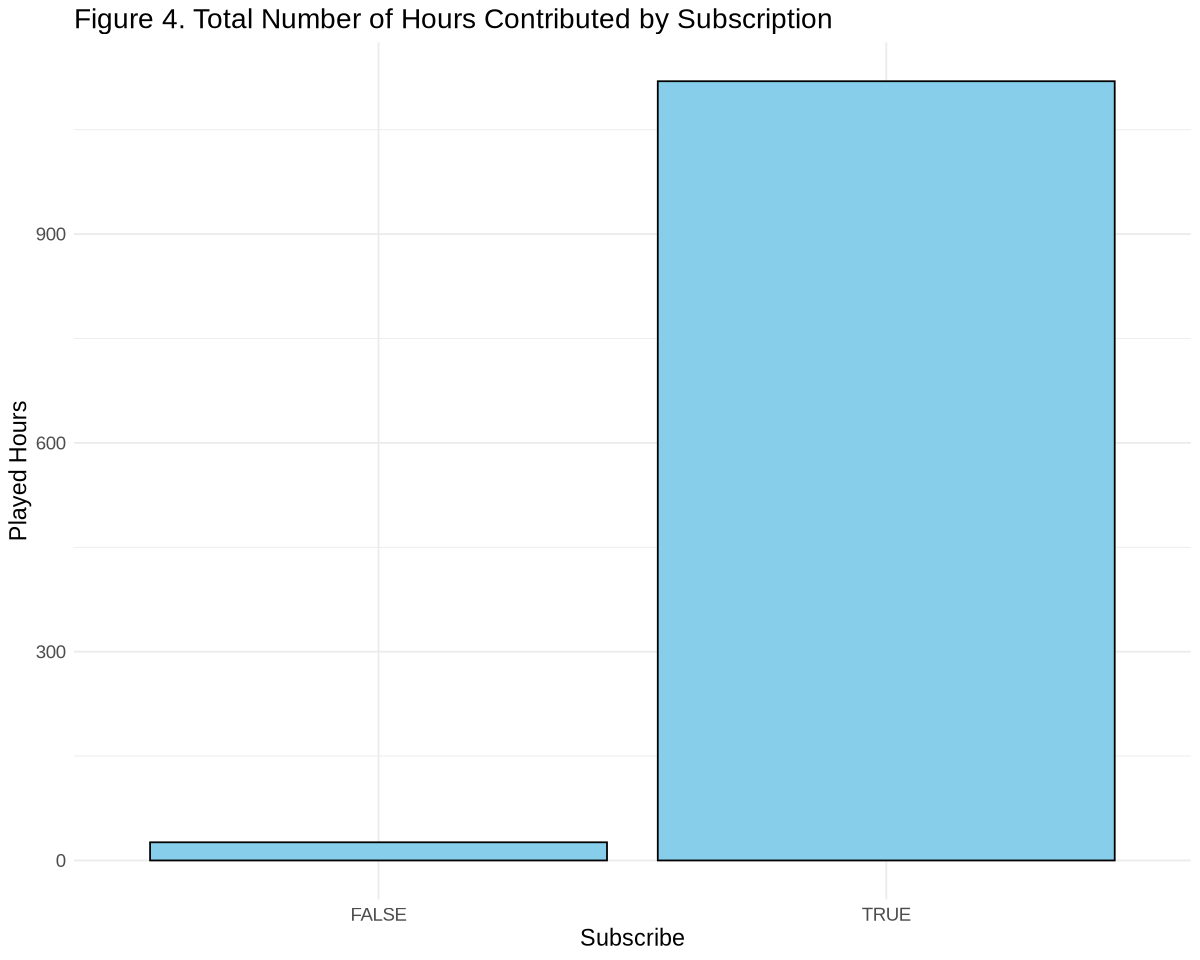

In [63]:
options(repr.plot.width = 10, repr.plot.height = 8)
subscribe_summary <- players_tidy |> 
  group_by(subscribe) |> 
  summarize(total_hours = sum(played_hours, na.rm = TRUE))

# Create the bar graph
ggplot(subscribe_summary, aes(x = subscribe, y = total_hours)) +
  geom_bar(stat = "identity", fill = "skyblue", color = "black") + 
  labs(
    title = "Figure 4. Total Number of Hours Contributed by Subscription",
    x = "Subscribe",
    y = "Played Hours"
  ) +
  theme_minimal() +
  theme(text = element_text(size = 14))

In [64]:
#convert the character variables to factor variables so they can be used as categories for KNN classification
players_tidy <- players_tidy |> 
    mutate(experience = as.factor(experience), 
           gender = as.factor(gender), 
           subscribe = as.factor(subscribe))

#record the levels
levels(players_tidy$gender)
levels(players_tidy$experience)
levels(players_tidy$subscribe)

[1] "Agender"           "Female"            "Male"             
[4] "Non-binary"        "Other"             "Prefer not to say"
[7] "Two-Spirited"

[1] "Amateur"  "Beginner" "Pro"      "Regular"  "Veteran"

[1] "FALSE" "TRUE"

In [65]:
#assign numerical values to the experience, and gender variables so they can be used to calculate distances between points in KNN classification
players_tidy <- players_tidy |> 
    mutate(experience = as.numeric(experience), 
           gender = as.numeric(gender), 
           subscribe = as.numeric(subscribe))

We started the analysis by loading the dataset from the URL. Unecessary columns such as "hashedEmail" and "name" were removed to simplify the data and focus on relevant variables. 

Categorical variables such as "experience", "gender", and "subscribe" were converted into numeric factors to make them more suitable for modelling. 

The next step was finding a certain number of playing hours to be defined as a "boundary"; any playing time below this boundary will be considered a "low contributor", and any playing time above this boundary will be considered a "high contributor". 

In [66]:
#calculate the average number of played hours to determine a boundary separating high and low contributors
median_played_hours <- players_tidy |>
  summarize(median_hours = median(played_hours, na.rm = TRUE)) |>
    pull()


print(paste("The median played hours is:", median_played_hours))

[1] "The median played hours is: 0.1"


The above code output reveals that the median number of played hours in the players data set is 0.1 hours. 

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


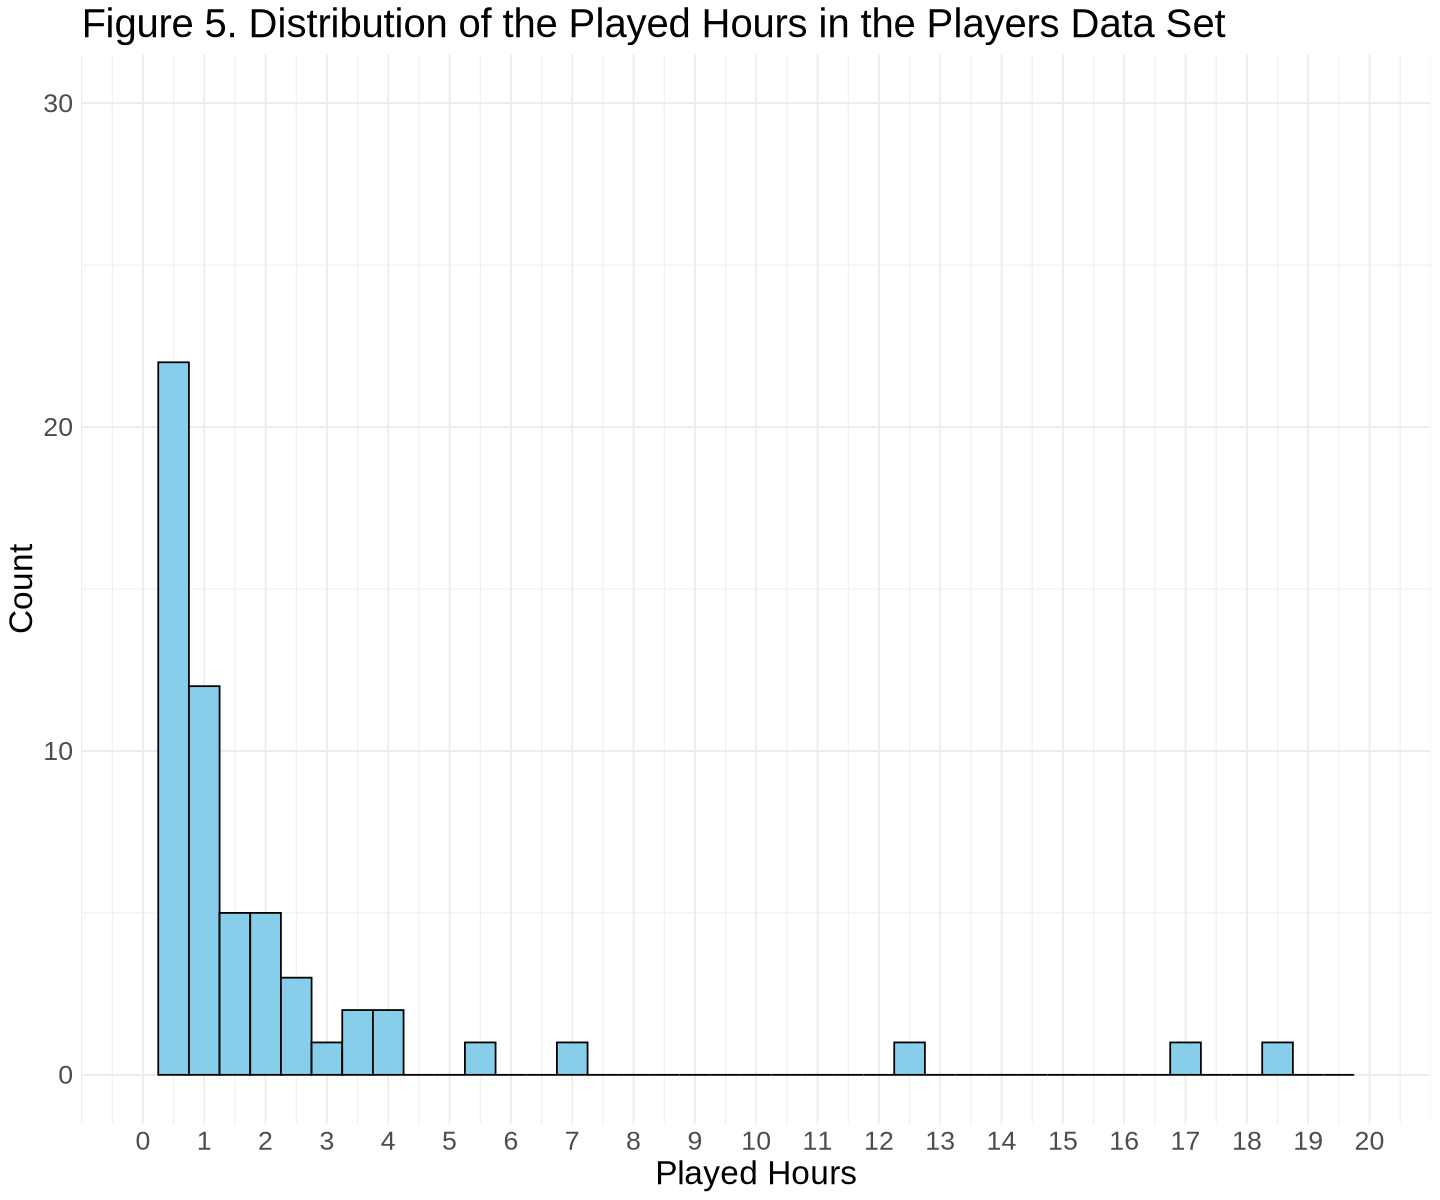

In [67]:
#create a histogram to visualize the distribution of the played_hours variable for the whole data set
options(repr.plot.width = 12, repr.plot.height = 10)
hours_dist <- ggplot(players_tidy, aes(x = played_hours)) + 
     geom_histogram(binwidth = 0.5, color = "black", fill = "skyblue") + 
     scale_x_continuous(breaks = seq(0, 20, by = 1), limits = c(0, 20)) +
     labs(x = "Played Hours", y = "Count") + 
     ggtitle("Figure 5. Distribution of the Played Hours in the Players Data Set")+ 
     scale_y_continuous(limits = c(0, 30)) +
     theme_minimal() +
     theme(text = element_text(size = 20))
hours_dist

We created a histogram showing the distribution of the played_hours variable. We set the maximum axis range to 20 to remove outliers. It is evident from the above code output that the data is skewed towards the median of 0.1 hours.

In [68]:
#calculate the number of players who contributed more than 0.1 hours
count_0.1_hours <- players_tidy |> 
    filter(played_hours > 0.1) |> 
    summarize(count = n()) 
count_0.1_hours

count
<int>
77


The above code output reveals that 77 players contributed more than 0.1 hours.

In [69]:
#calculate the number of players who contributed 0.5 hours or more
count_0.5_hours <- players_tidy |> 
    filter(played_hours >= 0.5) |> 
    summarize(count = n()) 
count_0.5_hours

count
<int>
57


The above code output reveals that 57 players contributed 0.5 hours or more. 

In [70]:
#calculate the number of players who contributed 0.5 hours or more
count_1_hour <- players_tidy |> 
    filter(played_hours >= 1) |> 
    summarize(count = n()) 
count_1_hour

count
<int>
42


The above code output reveals that 42 players contributed 1 hour or more.

In [71]:
#set the boundary separating High and Low Contributors 
boundary <- 1 #set it to 1 hour for now, can change this later. 

The median value of 0.1 hours (6 minutes) is not a high enough value to be classified as a low contributor, considering that there are outliers in the data set. For example, the histogram shows that the maximum value for the played_hours variable is 223 hours. Nonetheless, there are still a significant amount of players who contributed at least 1 hour.

Therefore, we classified players who contributed at least 1 hour as "high contributors" and players who contributed less than 1 hour as "low contributors."

In [72]:
#assign a contributor label to each played hours value
players_tidy <- players_tidy |> 
    mutate(contributor = factor(ifelse(played_hours > boundary, "High Contributor", "Low Contributor")))

A new binary variable "contributor" was mutated based on the boundary of 1 played hour in the dataset. 

In [73]:
#set the seed for the project
set.seed(2024) 

#Split the data into a train:test ratio of 3:1
players_split <- initial_split(players_tidy, prop = 0.75, strata = contributor)  
players_train <- training(players_split)   
players_test <- testing(players_split)

The modeling process began by splitting the data into 2 sets - a training set and a testing set with a ratio of 3:1. 

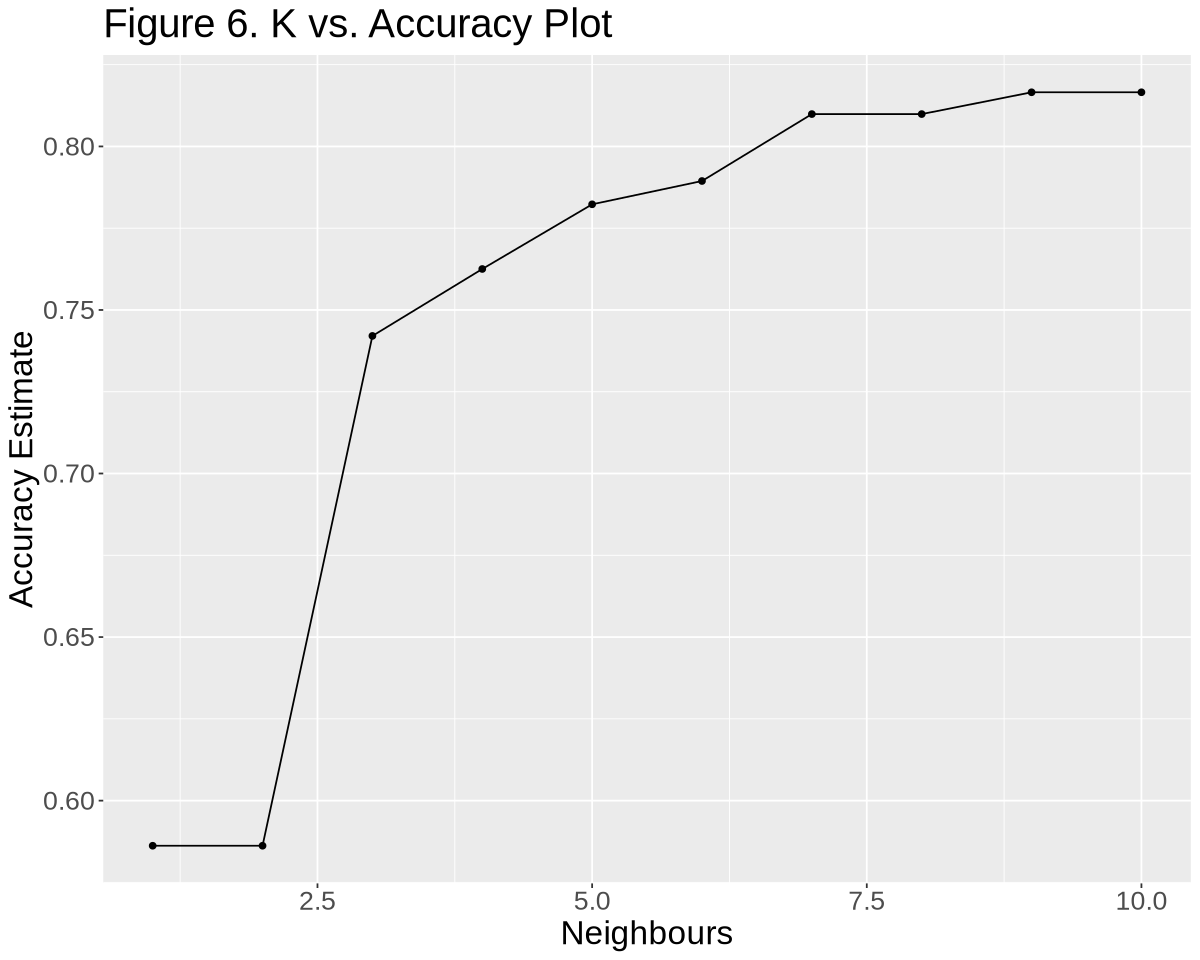

In [74]:
#select the best k value by making a k vs. accuracy plot
set.seed(2024) 
options(repr.plot.height = 8, repr.plot.width = 10)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

training_recipe <- recipe(contributor ~ experience + gender + age + subscribe , data = players_train)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 
    

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

training_vfold <- vfold_cv(players_train, v = 5, strata = contributor)

training_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = training_vfold, grid = k_vals) |>
  collect_metrics()

accuracy <- training_fit |> 
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+ 
    geom_point()+ 
    geom_line()+ 
    labs(x = "Neighbours", y = "Accuracy Estimate") + 
    ggtitle("Figure 6. K vs. Accuracy Plot") +
    theme(text = element_text(size = 20))
    
cross_val_plot


A KNN classification model was used to predict whether players were high or low contributors. The predictors we used are: 

- age
- experience
- gender
- subscribe

To find the optimal number of neighbours, k, we performed a 5-fold cross-validation, tuning the model over a range of k values (1 - 20). The K value with the highest accuracy (1) was chosen.

In [75]:
# Set the seed. Don't remove this!
set.seed(9999) 

# your code here
best_k <- accuracy |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(training_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

players_metrics <-  players_predictions|>
   metrics(truth = contributor, estimate = .pred_class)

players_conf_mat <- players_predictions|>
    conf_mat(truth = contributor, estimate = .pred_class)
players_conf_mat
players_metrics

                  Truth
Prediction         High Contributor Low Contributor
  High Contributor                0               0
  Low Contributor                 9              40

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8163265
kap,binary,0.0000000


The KNN model was trained with the optimal k value and was evaluated using the testing dataset. Our model's performance metrics resulted in 81.6% accuracy.

Additional visualizations were added to explore the distribution of high and low contributors across the key variables. We used separate histograms and bar plots to illustrate how age, gender, experience and subscription status influenced player contributions. 

In [76]:
#add a predicted contributor column to the players_test set
players_predictions <- players_predictions |> 
    mutate(
        predicted_contributor = .pred_class, 
        predicted_contributor = factor(predicted_contributor, levels = c("Low Contributor", "High Contributor")),
        #Convert numeric values back to categorical values
        gender = factor(gender, levels = 1:7, labels = c("Agender", "Female", "Male", "Non-binary", "Other", "Prefer not to say", "Two-Spirited")),
        experience = factor(experience, levels = 1:5, labels = c("Amateur", "Beginner", "Pro", "Regular", "Veteran")),
        subscribe = factor(subscribe, levels = 1:2, labels = c("FALSE", "TRUE")))


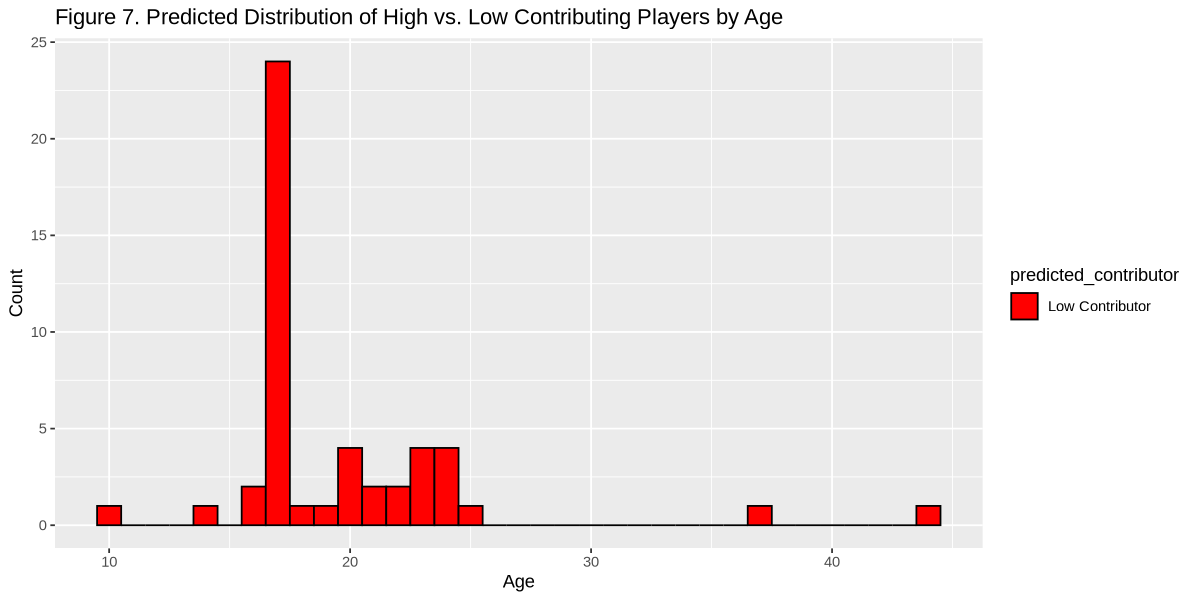

In [77]:
#create a histogram showing the distributions of high and low contributors by age
options(repr.plot.width = 10, repr.plot.height = 5)
age_contributor_plot <- ggplot(players_predictions, aes(x = age, fill = predicted_contributor)) +
  geom_histogram(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Age", y = "Count") +
  ggtitle("Figure 7. Predicted Distribution of High vs. Low Contributing Players by Age")
age_contributor_plot


For testing purpose

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


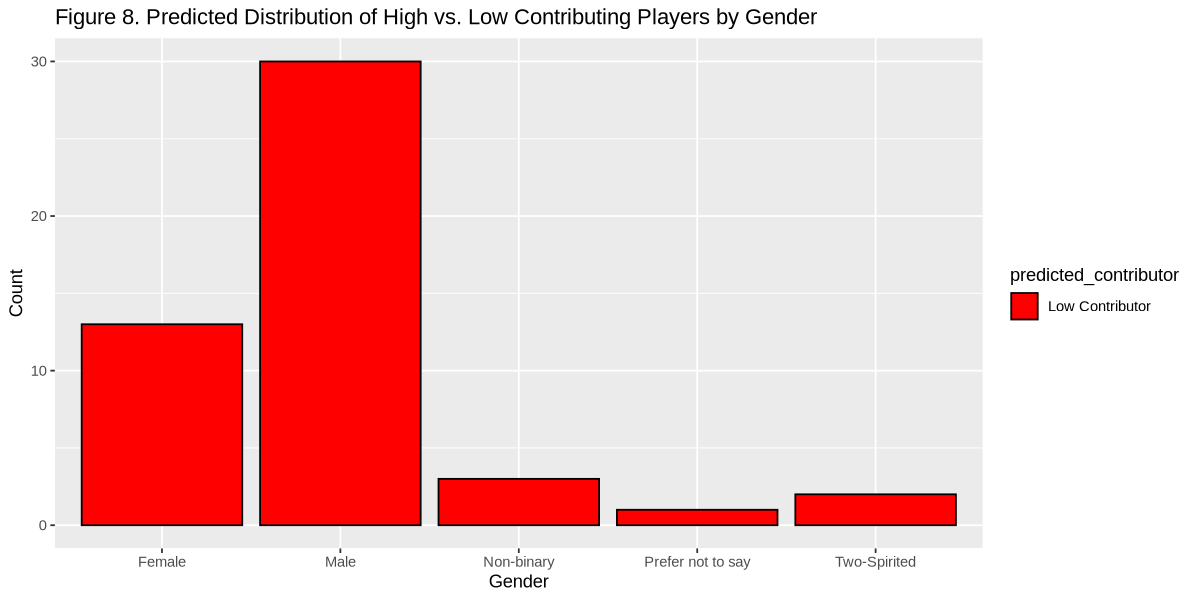

In [78]:
#create a histogram showing the distributions of high and low contributors by gender
gender_contributor_plot <- ggplot(players_predictions, aes(x = gender, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Gender", y = "Count") +
  ggtitle("Figure 8. Predicted Distribution of High vs. Low Contributing Players by Gender")
gender_contributor_plot

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


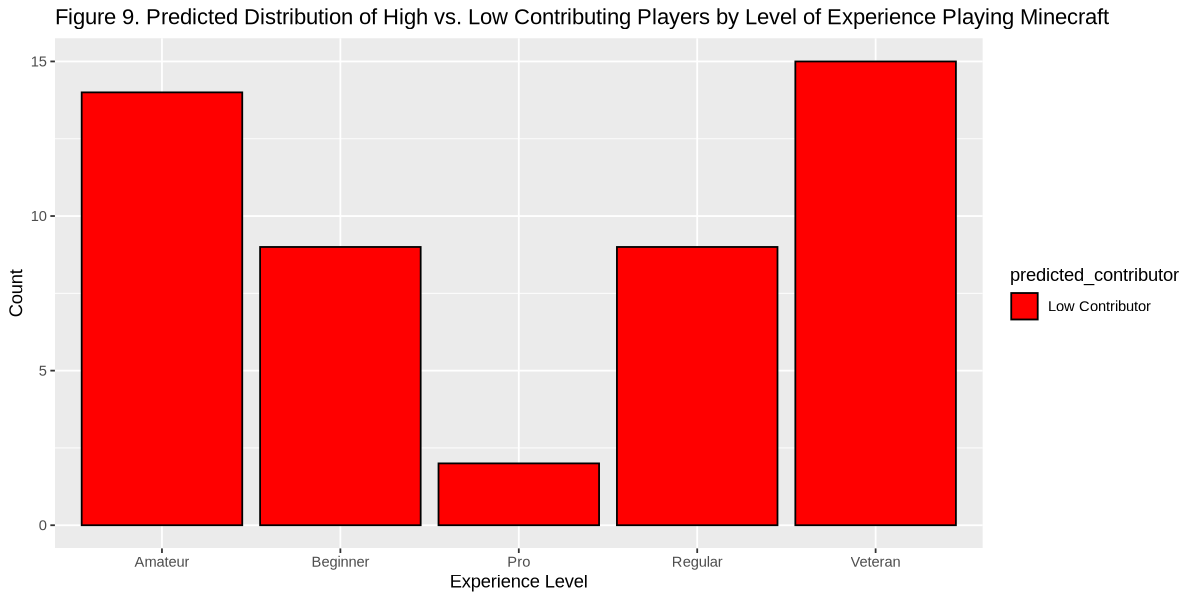

In [79]:
#create a histogram showing the distributions of high and low contributors by experience level
experience_contributor_plot <- ggplot(players_predictions, aes(x = experience, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Experience Level", y = "Count") +
  ggtitle("Figure 9. Predicted Distribution of High vs. Low Contributing Players by Level of Experience Playing Minecraft")
experience_contributor_plot

Warning message in geom_bar(binwidth = 1, color = "black"):
“Ignoring unknown parameters: `binwidth`”


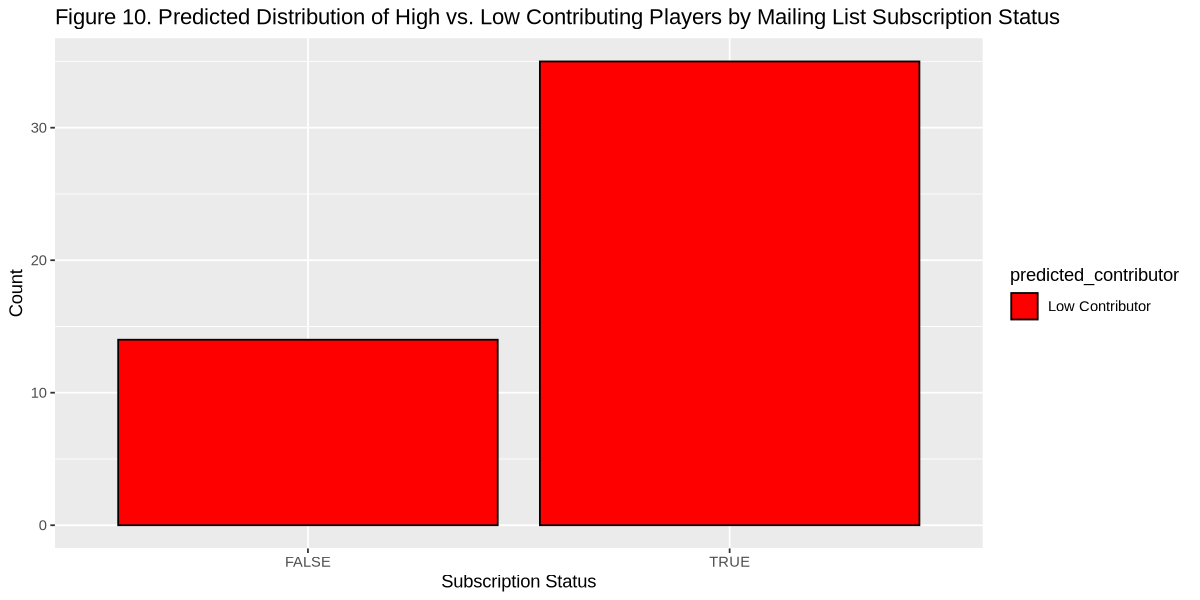

In [80]:
#create a histogram showing the distributions of high and low contributors by subscription status
subscribe_contributor_plot <- ggplot(players_predictions, aes(x = subscribe, fill = predicted_contributor)) +
  geom_bar(binwidth = 1, color = "black") +  
  scale_fill_manual(values = c("Low Contributor" = "red", "High Contributor" = "green3")) +  
  labs(x = "Subscription Status", y = "Count") +
  ggtitle("Figure 10. Predicted Distribution of High vs. Low Contributing Players by Mailing List Subscription Status")
subscribe_contributor_plot


## Discussion <br>

#### Discovery Summary <br>
In this project, we created a k-nn classification model to predict if a player is a high contributor(playtime > 1 hour) or a low contributor(playtime < 1 hour). However, it is impossible to find a fixed pattern of high contributors because of the limitations of the data and the model. <br><br>

First, our k-nn classification model uses players’ age, gender, Minecraft experience level and state of subscription as predictors. After testing, the model’s best-k is 9, accuracy is 81.63%. It predicts all 49 observations in the test set as low contributors, but 9 of them are actually high contributors.<br><br>

This fact shows that the characteristics of high contributors cannot be accurately summarized by existing models and data.<br><br>

First, the data we obtained is very limited. It has only 194 observations, 75% of which are used for training, as well as some disturbing values (e.g., a player's age is 99), which makes modelling difficult.<br><br>
Second, the median playtime of the dataset is 0.1 hour, which means that a large portion of the data is low contributors, therefore the k-nn classification tends to predict low contributors. This leads to the inability to summarize the pattern for high contributors.<br><br>

In conclusion, even though we have a k-nn classification model that can predict whether a player is a high contributor or not, we are still unable to summarize a clear image of high contributors through the model based on our existing knowledge.<br><br><br>


#### Difference from Expectation<br>

At the beginning of the project, we expected to build a k-nn classification model to help project staff predict how many hours players will contribute, and then distill the characteristics of high contributors from the model's prediction. Therefore the project team can target this group for promotion.<br><br>

However, in actual modelling, the given dataset is insufficient to build an accurate predictive model using k-nn classification. The performance of our model on the test set is the same as that of the majority classifier, so we are unable to extract any useful information from predictor variables.<br><br>

However, during the exploratory analysis of the data, we realized that some of the data looks like lies. We considered the possibility that the model might not be as good as expected due to these disturbing values. Since processing the data in detail is beyond the scope of this course, it is reasonable that the k-nn classification is unable to build a useful model with our current knowledge.<br><br><br>

#### Impact of discovery <br>

These findings prove that more data is needed to build a more useful predictive model and to capture the characteristics of high contributors. For now, everyone has the potential to be a high contributor. Recruiting a wide range of players is the best option at this point, rather than targeting a certain group of people.<br><br>
